# Imports

In [26]:
import numpy as np
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.utils import make_grid
# 필요한 라이브러리 임포트

# Paths
Defining the paths used for the dataset

In [27]:
monet_path = Path("../input/gan-getting-started/monet_jpg")
photo_path = Path("../input/gan-getting-started/photo_jpg")
# 경로지정, (내 컴퓨터로 할거면 다르게,)

Checking the number of images in each subfolder

In [28]:
len(list(monet_path.glob("**/*.jpg"))), len(list(photo_path.glob("**/*.jpg")))
# 몇개 있는지 확인

(300, 7038)

Checking an image simple from each class and to give a feel of the generated image we show a blended version of the two images. We calculate the blend as follow:
$$ B = (1-\alpha) \times X + \alpha \times Y$$

In [29]:
sample_monet, sample_photo = Image.open(list(monet_path.glob("**/*.jpg"))[0]), Image.open(list(photo_path.glob("**/*.jpg"))[0])
# Sample 로 모네랑 포토 하나씩 가져오기

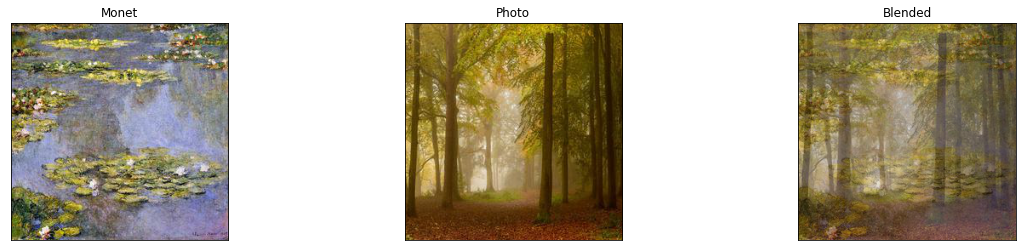

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
ax[0].imshow(sample_monet)
ax[0].set_title("Monet")
ax[0].set(xticks=[], yticks=[])
ax[1].imshow(sample_photo)
ax[1].set_title("Photo")
ax[1].set(xticks=[], yticks=[])
ax[2].imshow(Image.blend(sample_monet, sample_photo, 0.6)) # 섞는비율 (blend설정)
ax[2].set_title("Blended")
ax[2].set(xticks=[], yticks=[])
plt.show()
# 시각화

Check the image size and format

In [31]:
Image.open(list(photo_path.glob("**/*.jpg"))[0]).size, Image.open(list(photo_path.glob("**/*.jpg"))[0]).mode
# 포토의 size, mode 확인 (256, 256, RGB)

((256, 256), 'RGB')

In [32]:
Image.open(list(monet_path.glob("**/*.jpg"))[0]).size, Image.open(list(monet_path.glob("**/*.jpg"))[0]).mode
# 모네의 size, mode 확인 ,, 위와 동일

((256, 256), 'RGB')

# Dataset
Creating a PyTorch custom dataset

In [33]:
class MonetPhoto(Dataset): #MonetPhoto 클래스 생성
    def __init__(self, monet_path: Path = Path("../input/gan-getting-started/monet_jpg"), photo_path:Path = Path("../input/gan-getting-started/photo_jpg"), transform=None):
        self.monet_path = monet_path 
        self.monet_images = list(monet_path.glob("**/*.jpg"))
        self.photo_path = photo_path
        self.photo_images = list(photo_path.glob("**/*.jpg"))
        self.transform = transform 
    # path랑 image 받아오기
        
    def __len__(self): # 둘중 큰거 리턴
        return max(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx): # Monet, Photo, image, transform 시키기
        monet_image = Image.open(self.monet_images[idx % len(self.monet_images)]) #뒷부분 잘 모르겠음
        photo_image = Image.open(self.photo_images[idx % len(self.photo_images)])
        if self.transform:
            monet_image = self.transform(monet_image)
            photo_image = self.transform(photo_image)
        return monet_image, photo_image

Checking the dataset.
1. Note that we use PIL to open the pictures so we need to transforme them into a tensor
2. In addition an image size of (256, 256) migth be too big for a baseline so we resize it to (32, 32)

In [34]:
dataset = MonetPhoto(transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])) #이미지를 Tensor형식으로 transform 시키고, normalize시킴
# dataset = MonetPhoto(transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]))

We check the shape of one simple

In [35]:
x, y = dataset.__getitem__(1)
x.shape, y.shape # 확인

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

Note that the images has been normalized into a range of [-1, 1] since we will use a tanh activation on the output of the generator

In [36]:
x.max(), x.min(), y.max(), y.min() #Normalize잘됐는지 확인 max, min 값으로

(tensor(1.), tensor(-1.), tensor(1.), tensor(-1.))

We split the dataset into a train and test dataset with a ratio of 80%-20%

In [37]:
train_size, test_size = int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)
# train, test 8 : 2 로 나누려고 size 지정

In [38]:
training_data, testing_data = random_split(dataset, [train_size, test_size])
    # 자르기

We create the dataloaders
* This is not a classification problem so shuffling the data has no real meaning here, it's up to you

In [39]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=True, num_workers=2)
# 배치 사이즈 32, shuffle= T, 2코어로 DataLoader 객체 생성

In [40]:
next(iter(test_dataloader))[0][:32].shape 

torch.Size([32, 3, 256, 256])

In [41]:
for x, y in train_dataloader:
    print(x.size(), y.size()) # 아까 dataloader로 가져온 샘플 사이즈 확인
    break

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


# Model
For our baseline we are going to use a simple CNN model for the generator and the discriminator. The training process will follow the original GAN process without the cycle process. In the future we migth use a diffrent approch.

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device #device 설정

'cpu'

## Generator

In [43]:
class Generator(torch.nn.Module): #Generator 클래스 (nn.Module 사용) 생성
    def __init__( 
        self,
        in_channels: int = 50, #input 채널
        out_channels: int = 3, #output 채널
        nb_features: int = 32, # feature?
        nb_layers: int = 2, # layer는 2개
        device="cuda",
    ):
        super(Generator, self).__init__()
        self.device = device
        self.blocks = torch.nn.ModuleList( #nn.ModuleList, list형식으로 받아오기
            [
                self._block(
                    in_channels=in_channels, 
                    out_channels=nb_features * (2**0), # 진짜 이거 이해안됨 :(
                    kernel_size=(4, 4),
                    stride=2,
                    padding=1,
                    bias=False,
                    down=True
                )
            ] # 기본적인 설정들
        )
        for i in range(nb_layers): # layer마다 list형식으로 받아오는건 알겠는데, 채널 사이즈가 어떻게 이런식으로 되는지 이해 x
            self.blocks.append(
                self._block(
                    in_channels=nb_features * (2**i),
                    out_channels=nb_features * (2 ** (i + 1)),
                    kernel_size=(4, 4),
                    stride=2,
                    padding=1,
                    down=True
                )
            )
        for i in range(nb_layers, 0, -1):
            self.blocks.append(
                self._block(
                    in_channels=nb_features * (2 ** (i)),
                    out_channels=nb_features * (2 ** (i - 1)),
                    kernel_size=(2, 2),
                    stride=2,
                    bias=False,
                )
            )
        self.blocks.append(
            self._block(
                in_channels=nb_features,
                out_channels=out_channels,
                kernel_size=(2, 2),
                stride=2,
                activation=False,
                bias=True,
            )
        )

    def _block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: tuple = (4, 4),
        stride: int = 1,
        padding: int = 0,
        padding_mode: str = "reflect",
        bias: bool = False,
        activation: bool = True,
        down: bool = False
    ):
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                padding_mode=padding_mode,
                bias=bias,
                device=self.device,
            ) if down else torch.nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                bias=bias,
                device=self.device,
            ),
            torch.nn.Identity(device=self.device)
            if bias
            else torch.nn.BatchNorm2d(
                num_features=out_channels, eps=0.8, device=self.device
            ),
            torch.nn.LeakyReLU(0.2) if activation else torch.nn.Tanh(),
        ) # 활성화 함수 지정 LeakyRelu, Tanh 로 지정

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self.blocks:
            x = block(x)
        return x

## Discriminator

In [44]:
class Discriminator(torch.nn.Module): #Discrimnator 는 Generator와 반대
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 1,
        nb_features: int = 32,
        nb_layers: int = 2,
        device="cuda",
    ):
        super(Discriminator, self).__init__()
        self.device = device
        self.blocks = torch.nn.ModuleList( #얘도 똑같이 ModuleList로 Layer마다 list형태로
            [
                self._block(
                    in_channels=in_channels,
                    out_channels=nb_features,
                    kernel_size=(4, 4),
                    stride=2,
                    normalize=False,
                )
            ]
        )
        for i in range(nb_layers):
            self.blocks.append(
                self._block(
                    in_channels=nb_features * (2**i),
                    out_channels=nb_features * (2 ** (i + 1)),
                    kernel_size=(4, 4),
                    stride=2,
                    padding=1,
                )
            )
        self.blocks.append(
            self._block(
                in_channels=nb_features * (2**nb_layers),
                out_channels=out_channels,
                kernel_size=(2, 2), 
                stride=2,
                padding=0,
                normalize=False,
            )
        )

    def _block(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: tuple = (4, 4),
        stride: int = 1,
        padding: int = 0,
        padding_mode: str = "reflect",
        bias: bool = False,
        normalize: bool = True,
    ):
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                padding_mode=padding_mode,
                bias=bias,
                device=self.device,
            ),
            torch.nn.BatchNorm2d(num_features=out_channels, eps=0.8, device=self.device)
            if not bias and normalize
            else torch.nn.Identity(device=self.device),
            torch.nn.LeakyReLU(0.2), # 리키렐루를 활성화 함수로
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self.blocks:
            x = block(x)
        return x.view(x.size(0), -1)

## Sanitary check

In [45]:
# GAN 에서는 fake_img 생성해서 작동 확인 
generator = Generator(in_channels=3, nb_layers=4, device=device)
discriminator = Discriminator(nb_layers=5, device=device)
with torch.no_grad():
    fake_img = generator(torch.randn((1, 3, 256, 256), device=device))
    print(fake_img.shape)
    print(discriminator(fake_img).shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1])


# Trainer
I usually like to create a class handling the training, logging and model loading but this is just a preference.

In [46]:
class Trainer: # Trainer class 생성(이사람은 클래스 만들어서 한다고 함)
    def __init__(
        self,
        train_data: DataLoader,
        val_data: DataLoader,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        nb_epochs: int = 5,
        device: str = "cuda",
        save_path: str = None,
    ):
        self.train_data = train_data
        self.val_data = val_data
        self.generator = generator
        self.discriminator = discriminator
        self.nb_epochs = nb_epochs
        self.device = device
        self.save_path = Path(save_path) if save_path else save_path

        self.z = next(iter(self.val_data))[0][:32].to(self.device)
        
        self.logs = {
            "Step": [],
            "Train_g_loss": [],
            "Train_d_loss": [],
            "Val_g_loss": [],
            "Val_d_loss": [],
            "Samples": [],
        }

    def init_optimizers(self, lr: float=1e-3, betas: tuple=(0.5, 0.999)): # 옵티마이저 설정
        self.g_optimizer = torch.optim.Adam( # generator -> Adam으로
            self.generator.parameters(), lr=lr, betas=betas
        )
        self.d_optimizer = torch.optim.Adam( # discriminator -> Adam으로
            self.discriminator.parameters(), lr=lr, betas=betas
        )

    def train(self):
        assert (self.g_optimizer is not None) and (
            self.d_optimizer is not None
        ), "Please run Trainer().init_optimizer()"

        # Loading best model
        if self.save_path and self.save_path.exists():
            self.load_model()
            
        best_score = torch.inf

        for i in range(self.nb_epochs): #epoch 마다 loss 값 확인 ,, 밑에 validation 도 설정함
            train_d_loss, train_g_loss, val_d_loss, val_g_loss = 0, 0, 0, 0
            self.generator.train()
            self.discriminator.train()
            # Train loop
            loop = tqdm(
                enumerate(self.train_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} train",
                leave=False,
                total=len(self.train_data),
            )
            for step, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                # Train step
                g_loss, d_loss = self.train_step(x, y)

                train_g_loss += g_loss
                train_d_loss += d_loss

                loop.set_postfix_str(
                    f"g_loss: {train_g_loss / (step + 1) :.2f}, d_loss: {train_d_loss / (step + 1) :.2f}"
                )

            # Validation loop
            self.generator.eval()
            self.discriminator.eval()

            loop = tqdm(
                enumerate(self.val_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} validation",
                leave=True,
                total=len(self.val_data),
            )
            for step, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                # Validation step
                g_loss, d_loss = self.val_step(x, y)

                val_g_loss += g_loss
                val_d_loss += d_loss

                loop.set_postfix_str(
                    f"g_loss: {val_g_loss / (step + 1) :.2f} d_loss: {val_d_loss / (step + 1) :.2f}"
                )

            # Saving best model
            if self.save_path and best_score > val_g_loss:
                best_score = val_g_loss
                self.save_model()

            # Log
            self.log_metrics(
                step=i,
                train_g_loss=train_g_loss,
                train_d_loss=train_d_loss,
                val_g_loss=val_g_loss,
                val_d_loss=val_d_loss,
            )
        return self.logs

    def train_step( # train 함수
        self,
        x: torch.Tensor,
        y: torch.Tensor # Tensor로 바꿔주고
    ) -> tuple:
        self.g_optimizer.zero_grad(set_to_none=True) 
        self.d_optimizer.zero_grad(set_to_none=True) #g,d 둘다 옵티마이저 ㄱ
        
        fake_ = self.discriminator(
            self.generator(x)
        )
        real = self.discriminator(y)
        d_loss = ( # 평가 지표 Mean Square Error (얘는 fake랑 real이랑 비교해서 확인해줌)
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=self.device)) + 
            torch.nn.functional.mse_loss(fake_, torch.zeros_like(fake_, device=self.device)) 
        )

        d_loss.backward() 
        self.d_optimizer.step()
        
        fake = self.discriminator(
            self.generator(x)
        )
        
        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=self.device))
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def val_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> tuple:
        fake = self.discriminator(
            self.generator(x)
        )
        real = self.discriminator(y)
        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=self.device))
        d_loss = (
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=self.device)) + 
            torch.nn.functional.mse_loss(fake, torch.zeros_like(fake, device=self.device))
        )
        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def log_metrics(
        self,
        step: int,
        train_g_loss: torch.Tensor,
        train_d_loss: torch.Tensor,
        val_g_loss: torch.Tensor,
        val_d_loss: torch.Tensor,
    ):
        self.logs["Step"].append(step)
        self.logs["Train_g_loss"].append(train_g_loss / len(self.train_data))
        self.logs["Train_d_loss"].append(train_d_loss / len(self.train_data))
        self.logs["Val_g_loss"].append(val_g_loss / len(self.val_data))
        self.logs["Val_d_loss"].append(val_d_loss / len(self.val_data))
        self.logs["Samples"].append(make_grid(self.generator(self.z).cpu() * 0.5 + 0.5, normalize=True))

    def save_model(self, full: bool = False):
        if full:
            torch.save(self.generator, Path(self.save_path) / "generator.pth")
            torch.save(self.discriminator, Path(self.save_path) / "discriminator.pth")
        else:
            torch.save(
                self.generator.state_dict(),
                Path(self.save_path) / "generator_weights.pth",
            )
            torch.save(
                self.discriminator.state_dict(),
                Path(self.save_path) / "discriminator_weights.pth",
            )

    def load_model(self, full: bool = False):
        if (
            full
            and (self.save_path / "generator.pth").is_file()
            and (self.save_path / "discriminator.pth").is_file()
        ):
            self.generator = torch.load(self.save_path / "generator.pth")
            self.discriminator = torch.load(self.save_path / "discriminator.pth")
        elif (
            self.save_path / "generator_weights.pth"
        ).is_file() and (
            self.save_path / "discriminator_weights.pth"
        ).is_file():
            self.generator.load_state_dict(torch.load(self.save_path / "generator_weights.pth"))
            self.discriminator.load_state_dict(torch.load(self.save_path / "discriminator_weights.pth"))


# Train the models

In [47]:
trainer = Trainer(
        train_data = train_dataloader,
        val_data = test_dataloader,
        generator = Generator(in_channels=3, nb_layers=4, device=device),
        discriminator = Discriminator(nb_layers=5, device=device),
        nb_epochs = 30,
        device = device,
    )

In [48]:
trainer.device

'cpu'

In [ ]:
trainer.init_optimizers()
logs = trainer.train()

Epoch 10/30 train:  77%|███████▋  | 135/176 [24:49<07:31, 11.01s/it, g_loss: 1.06, d_loss: 0.15]

## Performance preview

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(logs["Step"], logs["Train_g_loss"], label="Train_g_loss")
ax[1].plot(logs["Step"], logs["Train_d_loss"], label="Train_d_loss")
ax[0].plot(logs["Step"], logs["Val_g_loss"], label="Val_g_loss")
ax[1].plot(logs["Step"], logs["Val_d_loss"], label="Val_d_loss")
ax[0].set_title("Generator loss")
ax[1].set_title("Discriminator loss")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(25, 15))
j, k = 0, 0
step = (len(logs["Step"])-1) // 9
for i in range(0, len(logs["Step"]) - 1, step if step > 0 else 1):
    axs[j, k].imshow(logs["Samples"][i+step  if step > 0 else i].permute(1, 2, 0))
    axs[j, k].set_title(f"Generated image at step {logs['Step'][i+step  if step > 0 else i]}")
    axs[j, k].set(xticks=[], yticks=[])
    if k >= 2:
        j += 1
        k = 0
    else:
        k += 1
    if k+j == 4:
        break
plt.show()

# Create submission file

In [ ]:
! mkdir ../images

In [ ]:
with torch.no_grad():
    for i, (img, _) in enumerate(DataLoader(dataset, batch_size=1, shuffle=False)):
        prediction = trainer.generator(img.to(device))[0].cpu().permute(1, 2, 0).numpy().astype(np.uint8)
#         prediction = trainer.generator(torch.randn((1, 50), device=device))[0].cpu().permute(1, 2, 0).numpy().astype(np.uint8)
        im = Image.fromarray(prediction)
        im.save(f"../images/{i}.jpg")

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")